In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Build your own convolutional neural network using pytorch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import  Subset

from torch.utils.data import random_split, Dataset
from torch.utils.data import TensorDataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import matplotlib.pyplot as plt

device = torch.device('cuda')

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = {
    'train':
    transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(size=224, scale=(0.5,0.5),ratio = (0.9,0.9)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomHorizontalFlip(p=0.4),

        transforms.ToTensor(),
        transforms.Normalize(
            mean,
            std)
    ]),
    'valid':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean,
            std)
    ])
}


In [ ]:
train_dataset = datasets.ImageFolder('/content/drive/My Drive/Train')

labels = [label for _, label in train_dataset]

train_size = int(0.85 * len(train_dataset))
valid_size = len(train_dataset) - train_size


# Create a StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=valid_size, random_state=42)

# Get the indices for the train and validation subsets
train_indices, valid_indices = next(sss.split(np.zeros(len(labels)), labels))

train_subset = Subset(train_dataset, train_indices)
valid_subset = Subset(train_dataset, valid_indices)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.subset)

train_subset = CustomDataset(train_subset, transform=transform['train'])
valid_subset = CustomDataset(valid_subset, transform=transform['valid'])


In [ ]:
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=128, shuffle=False)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for filename in os.listdir(root_dir):
            if filename.endswith('.jpg'):
                img_path = os.path.join(root_dir, filename)
                self.samples.append((img_path, filename))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, filename = self.samples[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, filename

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


transform2 = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_dataset1 = TestDataset(root_dir='/content/drive/My Drive/Test', transform=transform2)

test_loader = DataLoader(test_dataset1, batch_size=128, shuffle=False)

In [ ]:
class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1)
        )
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

In [ ]:
class residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1, use_inception=False):
        super(residual_block, self).__init__()
        self.expansion = 4
        self.use_inception = use_inception
        self.identity_downsample = identity_downsample

        if self.use_inception:
            # Use Inception block in place of the traditional conv layers in ResNet
            self.inception = Inception_block(in_channels, 64, 64, 128, 16, 32, 32)  # Change these values as needed
            # Ensure the Inception output matches the expected ResNet output
            self.conv = nn.Conv2d(256, out_channels*self.expansion, kernel_size=1, stride=stride)  # 256 is the sum of the output channels from Inception block
            self.bn0 = nn.BatchNorm2d(out_channels*self.expansion)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=1, padding=0)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
            self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x

        if self.use_inception:
            x = self.inception(x)
            x = self.conv(x)
            x = self.bn0(x)
        else:
            x = self.relu(self.bn1(self.conv1(x)))
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.bn3(self.conv3(x))

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


In [ ]:
class Residual(nn.Module):
    def __init__(self, residual_block, layers, image_channels, num_classes):
        super(Residual, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size = 7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)

        #resnet layers
        self.layer1 = self._make_layer(residual_block, layers[0], out_channels=64, stride=1, use_inception=True)
        self.layer2 = self._make_layer(residual_block, layers[1], out_channels=128, stride=2, use_inception=True)
        self.layer3 = self._make_layer(residual_block, layers[2], out_channels=256, stride=2, use_inception=True)
        self.layer4 = self._make_layer(residual_block, layers[3], out_channels=512, stride=2, use_inception=True)
        self.layer5 = self._make_layer(residual_block, layers[4], out_channels=1024, stride=2, use_inception=True)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(1024*4, 1024)
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(1024, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


    def _make_layer(self, block, num_residual_blocks, out_channels, stride, use_inception=False):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                          stride=stride),
                                                nn.BatchNorm2d(out_channels*4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride, use_inception=use_inception))
        self.in_channels = out_channels*4

        for i in range(num_residual_blocks - 1):
            layers.append(residual_block(self.in_channels, out_channels, use_inception=use_inception))

        return nn.Sequential(*layers)

In [ ]:
def IncepResnet(img_channels=3, num_classes=4):
    return Residual(residual_block, [3,3,5,3,3], img_channels, num_classes)


In [ ]:
def pseudo_labeling(model, test_loader, threshold=0.8):
    model.eval()
    pseudo_images = []
    pseudo_labels = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            outputs = F.softmax(model(data), dim=1)
            _, preds = torch.max(outputs, 1)
            for i in range(data.size(0)):
                if torch.max(outputs[i]) > threshold:
                    pseudo_images.append(data[i].cpu())
                    pseudo_labels.append(preds[i].cpu())

    if len(pseudo_images) == 0:
        return [], []

    return torch.stack(pseudo_images), torch.stack(pseudo_labels)




# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IncepResnet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

best_val_acc = 0
num_epochs = 500

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):

    # Pseudo-Labeling after each epoch
    pseudo_images, pseudo_labels = pseudo_labeling(model, test_loader)
    if len(pseudo_images) > 0:
        train_data_combined = ConcatDataset([train_subset, TensorDataset(pseudo_images, pseudo_labels)])
        train_loader = DataLoader(train_data_combined, batch_size=128, shuffle=True, drop_last=True)

    # Training Phase
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target.squeeze())
        total_train_loss += loss.item()
        _, predicted_train = outputs.max(1)
        correct_train += predicted_train.eq(target).sum().item()
        total_train += target.size(0)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    train_accuracy = 100. * correct_train / total_train
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {train_accuracy:.2f}%")

    # Validation Phase
    model.eval()
    total_val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            total_val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(target).sum().item()
    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = 100. * correct / len(valid_subset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)

    # Save model with highest validation accuracy
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')


Epoch [1/500], Training Accuracy: 33.50%
Epoch [1/500], Validation Loss: 1.1237, Validation Accuracy: 39.31%
Epoch [2/500], Training Accuracy: 42.21%
Epoch [2/500], Validation Loss: 1.3376, Validation Accuracy: 42.77%
Epoch [3/500], Training Accuracy: 42.21%
Epoch [3/500], Validation Loss: 1.1029, Validation Accuracy: 39.31%
Epoch [4/500], Training Accuracy: 43.85%
Epoch [4/500], Validation Loss: 1.0868, Validation Accuracy: 42.77%
Epoch [5/500], Training Accuracy: 46.31%
Epoch [5/500], Validation Loss: 1.0627, Validation Accuracy: 42.77%
Epoch [6/500], Training Accuracy: 53.48%
Epoch [6/500], Validation Loss: 0.9357, Validation Accuracy: 60.12%
Epoch [7/500], Training Accuracy: 54.92%
Epoch [7/500], Validation Loss: 1.0209, Validation Accuracy: 63.01%
Epoch [8/500], Training Accuracy: 53.12%
Epoch [8/500], Validation Loss: 1.0283, Validation Accuracy: 58.96%
Epoch [9/500], Training Accuracy: 52.12%
Epoch [9/500], Validation Loss: 0.9694, Validation Accuracy: 61.85%
Epoch [10/500], Tra

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.ylim(0,5)  # Setting the y-axis limits here
plt.show()


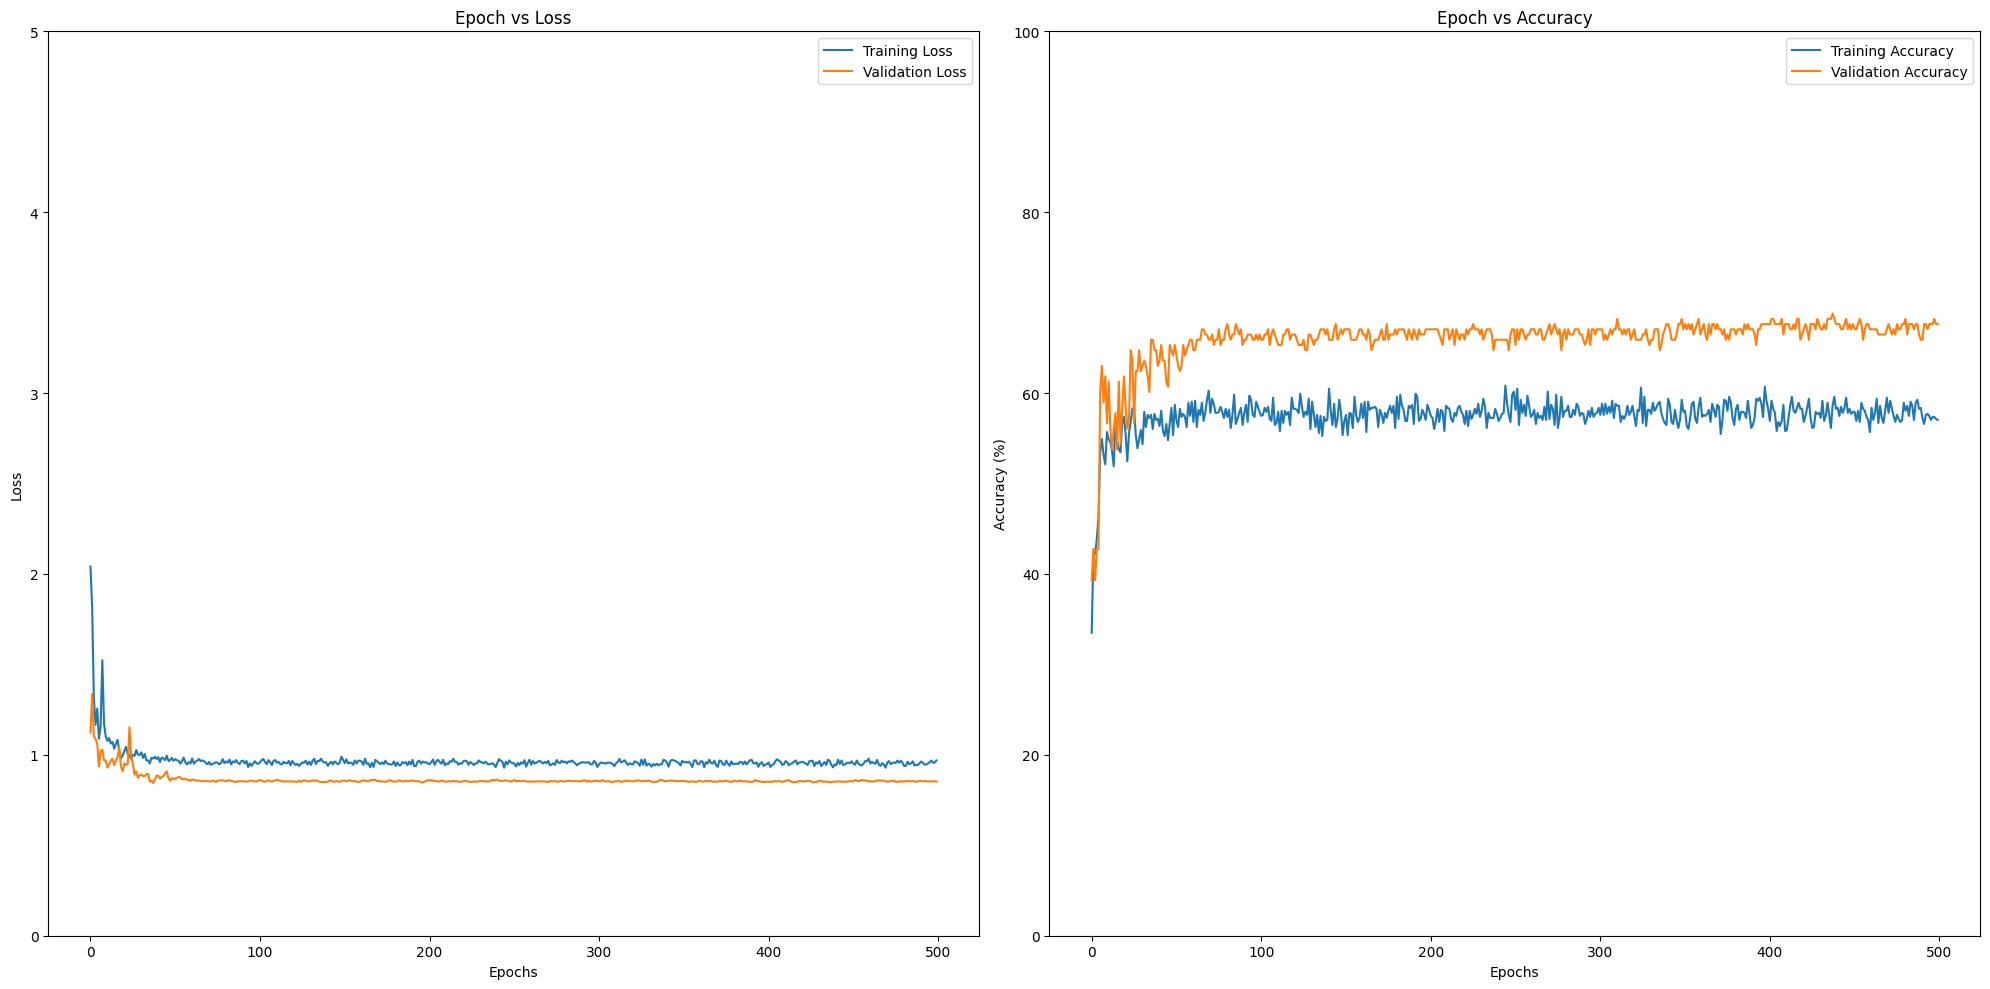

In [ ]:
plt.figure(figsize=(20, 10))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.ylim(0, 5)  # Setting the y-axis limits here

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.ylim(0, 100)  # Setting the y-axis limits here for accuracy

plt.tight_layout()
plt.show()


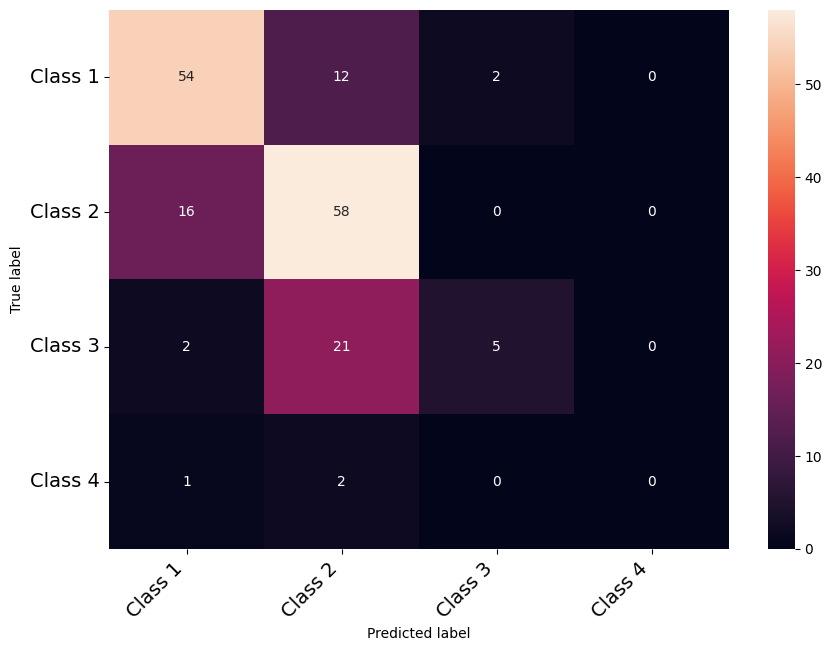

In [ ]:
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
plot_confusion_matrix(cm, class_names)



# 3. Evaluate your model using the developed software

In [ ]:
# Define the device
device = torch.device("cuda:0")

model = IncepResnet()

model.load_state_dict(torch.load('best_model.pth'))

model.to(device)

model.eval()

filenames = []
predictions = []

with torch.no_grad():
    for data, filename in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1) 
        filenames.extend(filename)
        predictions.extend(predicted.cpu().numpy().tolist())

model.train()

import pandas as pd

df_output = pd.DataFrame({
    'Filename': filenames,
    'Prediction': predictions
})

df_output.to_csv('IncepRes_predictions.csv', index=False, header=False)


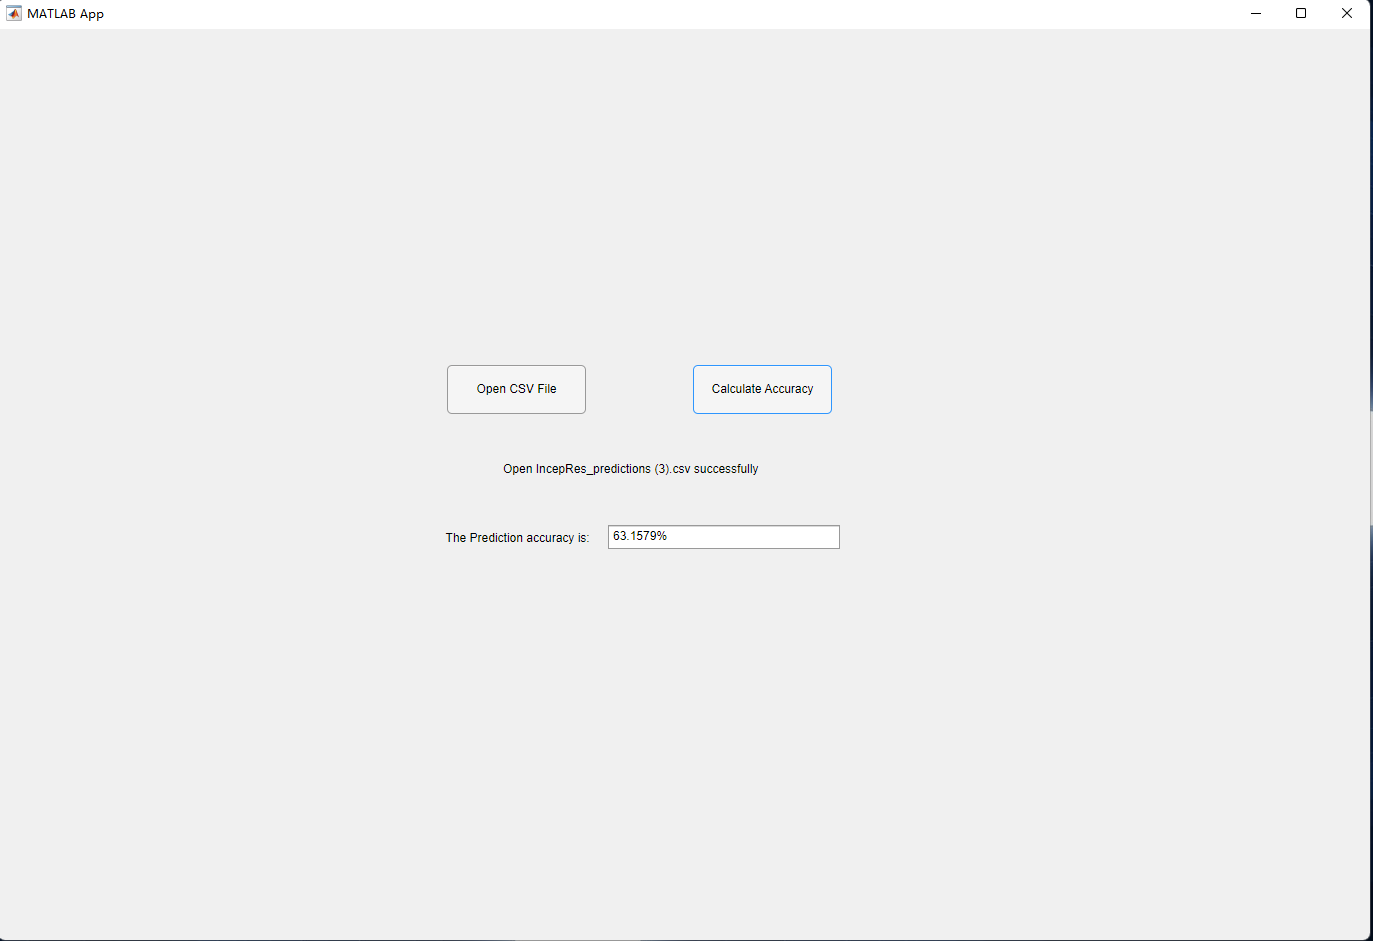

In [1]:
from IPython.display import display, Image

with open("incepres.PNG", "rb") as image_file:
    image_data = image_file.read()

display(Image(data=image_data))

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

### https://www.researchgate.net/publication/375233006_Use_Very_Deep_Convolution_Neural_Network_to_make_Cows_Teat-End_Classification

### https://github.com/DengyiLiu/DL-Project1/blob/main/best_model.pth

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 66.8% -->10 points
     < 40 % -->0 points
     >= 40 % & < 66.8% --> 0.3731 point/percent
     

(6). Discussion - 10 points